# 1. IMPORTATION DES LIBRAIRIES:


In [ ]:
import re # Bibliothèque standard de Python pour manipuler les expressions régulières
import nltk # Natural Language Toolkit : bibliothèque pour le traitement automatique du langage naturel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter # Outil de la bibliothèque standard Python pour compter la fréquence des éléments
from wordcloud import WordCloud
# Prétraitement et ML
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)
from imblearn.over_sampling import SMOTE

# Configuration des graphiques
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Téléchargement des ressources NLTK
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')


# 2. CHARGEMENT ET EXPLORATION DES DONNÉES:


In [ ]:
# Chargement des données
data = pd.read_csv('spam.csv')

# Informations générales
print(f"📋 Shape du dataset: {data.shape}")
print(f"📋 Colonnes: {list(data.columns)}")
print(f"📋 les doublons : {data.duplicated().sum()}")
print(f"📋 Valeurs manquantes:\n{data.isnull().sum()}")
print(f"📋 Messages vides :\n{(data['Message'].str.strip() == '').sum()}")
print(f"\n📋 Premiers échantillons:")
data.drop_duplicates(inplace=True)
print(data.head())

# Distribution des classes
print(f"\n📋 Distribution des classes:")
class_dist = data['Category'].value_counts()
print(class_dist)
print(f"\n📋 Pourcentages:")
print(data['Category'].value_counts(normalize=True) * 100)


📋 Shape du dataset: (5572, 2)
📋 Colonnes: ['Category', 'Message']
📋 les doublons : 415
📋 Valeurs manquantes:
Category    0
Message     0
dtype: int64
📋 Messages vides :
0

📋 Premiers échantillons:
  Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...

📋 Distribution des classes:
Category
ham     4516
spam     641
Name: count, dtype: int64

📋 Pourcentages:
Category
ham     87.570293
spam    12.429707
Name: proportion, dtype: float64


*Interprétation* :

Le dataset est propre (pas de valeurs manquantes, pas de messages vides).

Il contient un nombre significatif de doublons à retirer.

La classe majoritaire est "ham", la minoritaire est "spam" → problème de class imbalance qu’il faudra traiter.

Le prétraitement linguistique est crucial étant donné la nature informelle des messages.

# 3. ANALYSE EXPLORATOIRE DES DONNÉES (EDA)

/tmp/ipython-input-1170183778.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='Category', palette='Set2')


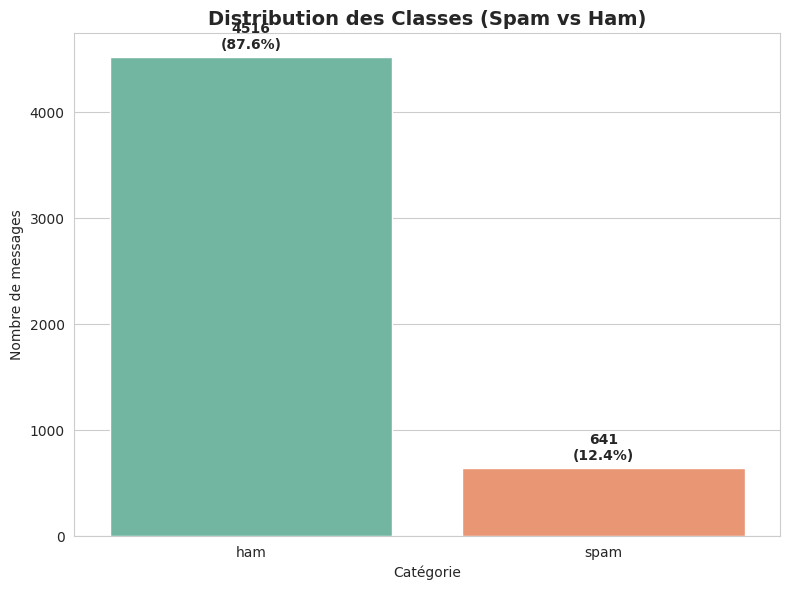

In [ ]:
# 3.1 Distribution des classes - Graphique
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='Category', palette='Set2')
plt.title("Distribution des Classes (Spam vs Ham)", fontsize=14, fontweight='bold')
plt.xlabel("Catégorie")
plt.ylabel("Nombre de messages")
# Ajouter les pourcentages sur les barres
total = len(data)
for i, v in enumerate(data['Category'].value_counts().values):
    plt.text(i, v + 50, f'{v}\n({v/total*100:.1f}%)',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

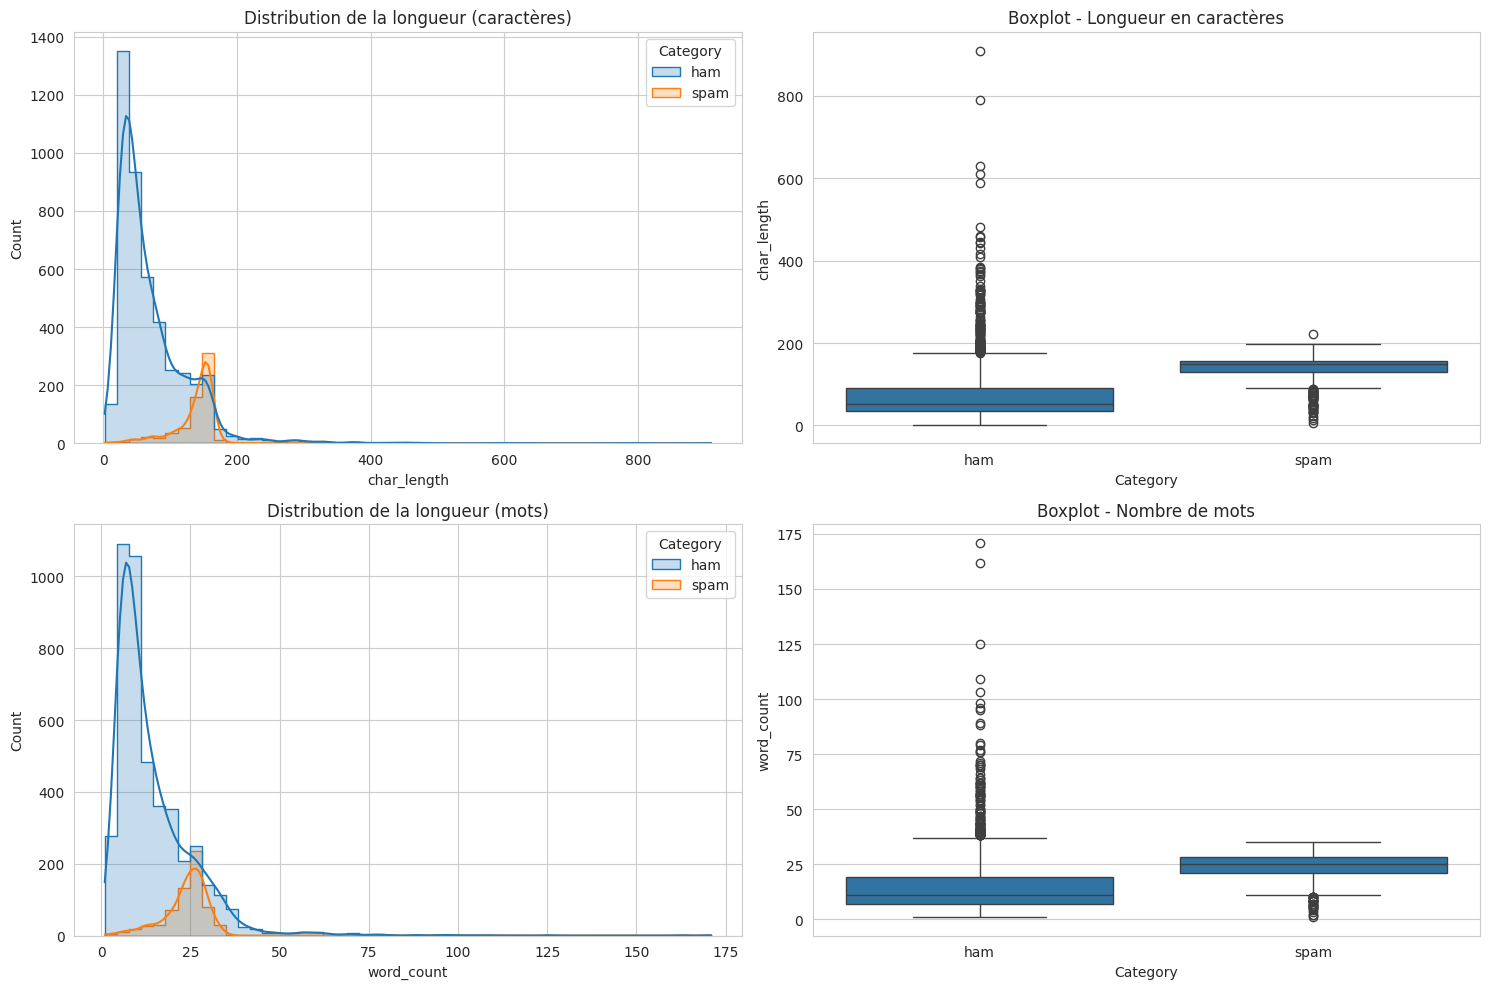

In [ ]:




# 3.2 Analyse de la longueur des messages
data['char_length'] = data['Message'].apply(len)
data['word_count'] = data['Message'].apply(lambda x: len(x.split()))



# Graphiques de distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribution des caractères
sns.histplot(data=data, x='char_length', hue='Category', bins=50,
            kde=True, element="step", ax=axes[0,0])
axes[0,0].set_title("Distribution de la longueur (caractères)")

# Boxplot des caractères
sns.boxplot(data=data, x='Category', y='char_length', ax=axes[0,1])
axes[0,1].set_title("Boxplot - Longueur en caractères")

# Distribution des mots
sns.histplot(data=data, x='word_count', hue='Category', bins=50,
            kde=True, element="step", ax=axes[1,0])
axes[1,0].set_title("Distribution de la longueur (mots)")

# Boxplot des mots
sns.boxplot(data=data, x='Category', y='word_count', ax=axes[1,1])
axes[1,1].set_title("Boxplot - Nombre de mots")

plt.tight_layout()
plt.show()


In [ ]:
# Statistiques descriptives
print("\n📈 Statistiques de longueur des messages:")
length_stats = data.groupby('Category')[['char_length', 'word_count']].describe()
print(length_stats)


📈 Statistiques de longueur des messages:
         char_length                                                          \
               count        mean        std  min    25%    50%    75%    max   
Category                                                                       
ham           4516.0   70.869353  56.708301  2.0   34.0   53.0   91.0  910.0   
spam           641.0  137.118565  30.399707  7.0  130.0  148.0  157.0  223.0   

         word_count                                                      
              count       mean        std  min   25%   50%   75%    max  
Category                                                                 
ham          4516.0  14.239814  11.179471  1.0   7.0  11.0  19.0  171.0  
spam          641.0  23.659906   6.038659  1.0  21.0  25.0  28.0   35.0  


*Interprétation* :     
Les messages spam ont tendance à être plus longs, plus homogènes et plus informatifs.

Les messages ham sont plus courts et variés.

La longueur (caractères, mots) est donc un bon indicateur pour différencier les deux catégories.

# 4. ANALYSE DES PATTERNS TEXTUELS:

In [ ]:
def get_top_ngrams(corpus, n=1, top_k=15):
    """Extrait les n-grammes les plus fréquents"""
    # - ngram_range=(n,n) → on choisit des unigrams (1 mot), bigrams (2 mots).
    # - stop_words="english" → on supprime les stop_words .
    # - max_features=5000 → on limite le vocabulaire aux 5000 mots/phrases les plus fréquents
    vec = CountVectorizer(ngram_range=(n,n), stop_words="english",
                         max_features=5000).fit(corpus)
    # Transformation du corpus en matrice de fréquence (bag of words)
    bag_of_words = vec.transform(corpus)

    # Somme des fréquences de chaque mot/gramme sur l’ensemble du corpus
    sum_words = bag_of_words.sum(axis=0)

    words_freq = [(word, int(sum_words[0, idx]))
                 for word, idx in vec.vocabulary_.items()]
    return sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_k]

# Analyse par classe
for label in data['Category'].unique():
    print(f"\n📝 Top unigrams pour {label.upper()}:")
    unigrams = get_top_ngrams(data[data['Category']==label]['Message'], n=1)
    for word, freq in unigrams[:10]:
        print(f"  {word}: {freq}")

    print(f"\n📝 Top bigrams pour {label.upper()}:")
    bigrams = get_top_ngrams(data[data['Category']==label]['Message'], n=2)
    for word, freq in bigrams[:10]:
        print(f"  {word}: {freq}")




📝 Top unigrams pour HAM:
  gt: 288
  lt: 287
  just: 282
  ok: 256
  ll: 233
  got: 227
  know: 226
  like: 224
  good: 217
  come: 214

📝 Top bigrams pour HAM:
  lt gt: 254
  let know: 40
  good morning: 24
  don know: 22
  new year: 21
  just got: 20
  ok lor: 19
  hi hi: 18
  wat time: 18
  lt decimal: 18

📝 Top unigrams pour SPAM:
  free: 190
  txt: 132
  ur: 119
  stop: 110
  text: 108
  mobile: 105
  reply: 96
  claim: 94
  www: 81
  prize: 78

📝 Top bigrams pour SPAM:
  po box: 21
  prize guaranteed: 19
  send stop: 19
  1000 cash: 17
  urgent mobile: 17
  national rate: 17
  selected receive: 16
  txt stop: 16
  land line: 16
  valid 12hrs: 15


*Interprétation *   
Les ham utilisent un langage personnel, informel, émotionnel, lié à des conversations entre individus.

Les spam utilisent un langage stéréotypé, commercial et incitatif, visant à attirer l’attention, créer un sentiment d’urgence et pousser à l’action.

👉 Ces différences de vocabulaire sont de bons indicateurs discriminants pour l’entraînement d’un modèle de détection automatique du spam.

In [ ]:
# Analyse TF-IDF pour identifier les mots discriminants
print("\n🎯 MOTS DISCRIMINANTS (TF-IDF)")
print("-" * 30)
# Vectorisation TF-IDF (mesure l’importance des mots en tenant compte de leur rareté)
tfidf_analyzer = TfidfVectorizer(stop_words="english", max_features=5000)
tfidf_matrix = tfidf_analyzer.fit_transform(data['Message'])
feature_names = np.array(tfidf_analyzer.get_feature_names_out())

# Moyenne TF-IDF par classe
spam_idx = data['Category'] == "spam"
ham_idx = data['Category'] == "ham"

spam_mean = np.asarray(tfidf_matrix[spam_idx.to_numpy()].mean(axis=0)).flatten()
ham_mean = np.asarray(tfidf_matrix[ham_idx.to_numpy()].mean(axis=0)).flatten()

# Top indicateurs
top_spam_idx = np.argsort(spam_mean - ham_mean)[-15:]
top_ham_idx = np.argsort(ham_mean - spam_mean)[-15:]

print(f"🚨 Top indicateurs SPAM: {list(feature_names[top_spam_idx])}")
print(f"✅ Top indicateurs HAM: {list(feature_names[top_ham_idx])}")


🎯 MOTS DISCRIMINANTS (TF-IDF)
------------------------------
🚨 Top indicateurs SPAM: ['won', 'cash', 'uk', '150p', 'service', 'urgent', 'www', 'text', 'reply', 'prize', 'stop', 'claim', 'mobile', 'txt', 'free']
✅ Top indicateurs HAM: ['did', 'oh', 'later', 'like', 'good', 'da', 'going', 'home', 'lor', 'got', 'll', 'come', 'lt', 'gt', 'ok']


*Interprétation :*    
👉 Les scores TF-IDF confirment que les différences lexicales entre les deux classes sont fortement discriminantes et peuvent être exploitées par les modèles de classification.

In [ ]:
#Compter les ponctuations pour spam et ham
import pandas as pd
from collections import Counter
import string

# Liste des ponctuations à analyser
punctuations = string.punctuation

def count_punct(df, label):
    texts = df.loc[df['Category'] == label, 'Message'].dropna()
    all_text = " ".join(texts)
    counts = Counter(char for char in all_text if char in punctuations)
    df_counts = pd.DataFrame.from_dict(counts, orient='index', columns=['Frequency'])
    df_counts = df_counts.sort_values(by='Frequency', ascending=False)
    return df_counts

# Fréquence des ponctuations dans le spam
spam_punct = count_punct(data, 'spam')
print("Ponctuations dans les messages spam :")
print(spam_punct)

# Fréquence des ponctuations dans le ham
ham_punct = count_punct(data, 'ham')
print("\nPonctuations dans les messages ham :")
print(ham_punct)


Ponctuations dans les messages spam :
   Frequency
.       1320
!        444
,        324
/        321
-        208
:        163
?        159
&        155
*        107
'        101
+         74
)         56
(         47
>         29
@         25
=         21
"         19
#          7
<          6
$          4
_          3
]          3
[          3
%          3
;          2

Ponctuations dans les messages ham :
   Frequency
.       8780
'       1620
,       1396
?       1331
!        802
;        679
&        658
:        488
)        392
-        308
#        257
*        178
"        157
(         61
/         45
|         36
+         31
=         22
$         19
@          9
_          8
%          7
~          3
\          2
]          2
[          2
^          1
>          1


*Interprétation:*  
les messages ham utilisent la ponctuation pour structurer une conversation, tandis que les spams exploitent certains symboles de manière excessive ou artificielle pour capter l’attention et inciter à l’action.

# 5. PRÉTRAITEMENT DES DONNÉES :

In [ ]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

# Télécharger les stopwords
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')


# Initialisation des outils de prétraitement
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Prétraitement spécifique au spam
def preprocess_spam(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    # Garder certaines ponctuations typiques du spam : ! / + >
    text = re.sub(r'http\S+|www\S+', '', text)   # URLs
    text = re.sub(r'\S+@\S+', '', text)          # emails
    text = re.sub(r'\+?\d[\d -]{8,}\d', '', text)  # numéros de téléphone
    text = re.sub(r'[^a-z\s!/+>]', '', text) # garder lettres et ponctuations importantes
    words = [stemmer.stem(word) for word in text.split() if word not in stop_words]
    return " ".join(words)

# Prétraitement spécifique au ham
def preprocess_ham(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)   # URLs
    text = re.sub(r'\S+@\S+', '', text)          # emails
    text = re.sub(r'\+?\d[\d -]{8,}\d', '', text)  # numéros de téléphone
    text = re.sub(r'[^a-z\s!/+>]', '', text) # garder lettres et ponctuations importantes
    words = [stemmer.stem(word) for word in text.split() if word not in stop_words]
    return " ".join(words)

# Application du prétraitement selon la classe
print("Nettoyage des textes par catégorie...")
data['cleaned'] = data.apply(
    lambda row: preprocess_spam(row['Message']) if row['Category'] == 'spam' else preprocess_ham(row['Message']),
    axis=1
)
data.head()

Nettoyage des textes par catégorie...


,Category,Message,char_length,word_count,cleaned
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,29,6,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,free entri wkli comp win fa cup final tkt st m...
3,ham,U dun say so early hor... U c already then say...,49,11,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,nah dont think goe usf live around though


*Interprétation* :

Le prétraitement a permis de réduire le bruit et les variations inutiles, tout en préservant les signaux discriminants entre spam et ham.

Ce nettoyage est adapté pour l’entraînement d’un modèle classique de détection de spam (Naive Bayes, Logistic Regression, Random Forest) car il met en évidence les mots et motifs caractéristiques de chaque classe.

In [ ]:
# Supprimer les messages vides après nettoyage
data = data[data['cleaned'].str.strip() != ""].copy()

# Vérification des messages vides après nettoyage
empty_count = (data['cleaned'].str.strip() == "").sum()
print(f"Messages vides après nettoyage : {empty_count}")



Messages vides après nettoyage : 0


# 6. CRÉATION DES NUAGES DE MOTS :

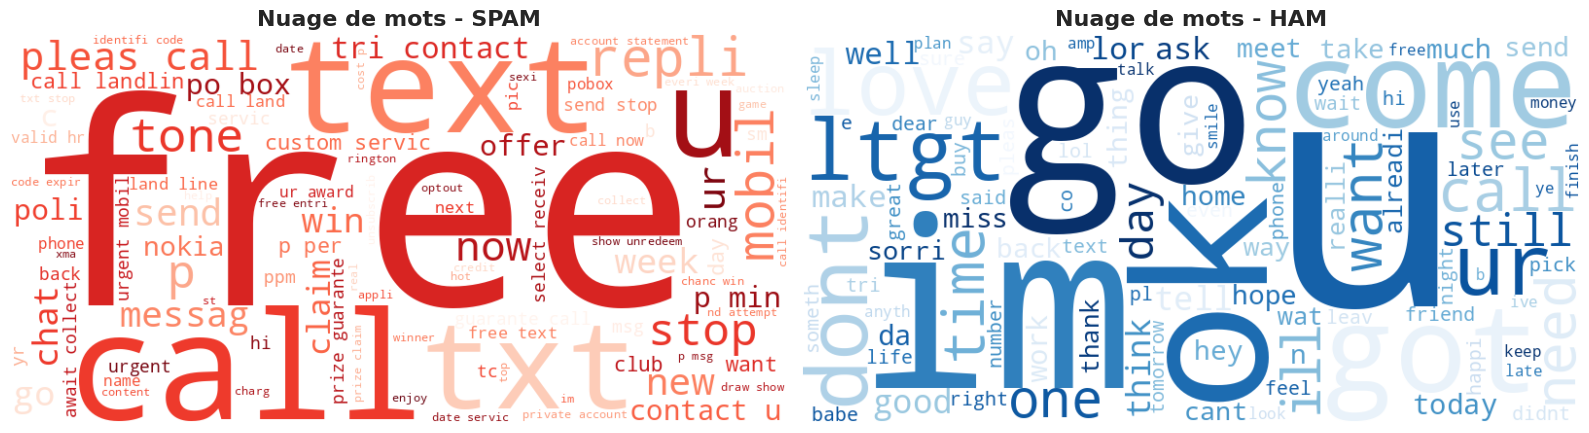

In [ ]:
# Texte combiné par catégorie
spam_text = " ".join(data[data['Category']=='spam']['cleaned'])
ham_text = " ".join(data[data['Category']=='ham']['cleaned'])

# Création des nuages de mots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Nuage SPAM
spam_wordcloud = WordCloud(
    width=800, height=400,
    background_color='white',
    colormap='Reds',
    max_words=100
).generate(spam_text)

axes[0].imshow(spam_wordcloud, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title("Nuage de mots - SPAM", fontsize=16, fontweight='bold')

# Nuage HAM
ham_wordcloud = WordCloud(
    width=800, height=400,
    background_color='white',
    colormap='Blues',
    max_words=100
).generate(ham_text)

axes[1].imshow(ham_wordcloud, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title("Nuage de mots - HAM", fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

**Interprétations :**  
Les spams se caractérisent par un vocabulaire promotionnel, direct et répétitif, orienté vers l’action et les gains.

Les hams utilisent un vocabulaire quotidien et relationnel, plus varié et naturel.

Les nuages de mots confirment les analyses précédentes (TF-IDF et n-grams) et montrent visuellement les différences lexicales entre les deux classes, ce qui est très utile pour la classification automatique.

# 7. PRÉPARATION DES DONNÉES POUR L'ENTRAÎNEMENT :

In [ ]:
# Séparation des features et target
X = data['cleaned']
y = data['Category']

# Split train/test stratifié
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"📊 Taille du train: {len(X_train)}")
print(f"📊 Taille du test: {len(X_test)}")
print(f"📊 Distribution train:\n{y_train.value_counts(normalize=True)}")


📊 Taille du train: 4120
📊 Taille du test: 1031
📊 Distribution train:
Category
ham     0.875485
spam    0.124515
Name: proportion, dtype: float64


In [ ]:
# Vectorisation TF-IDF
print("\nVectorisation TF-IDF...")
tfidf = TfidfVectorizer(
    max_features=5000,
    min_df=2,
    max_df=0.95,
    ngram_range=(1, 2),   token_pattern=r'(?u)\b\w+\b|[!/+>]'  # capture mots et ponctuations importantes
)


X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"📊 Shape des features: {X_train_tfidf.shape}")



Vectorisation TF-IDF...
📊 Shape des features: (4120, 5000)


In [ ]:
# SMOTE pour équilibrer les classes
print("\nApplication de SMOTE")
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_tfidf, y_train)

print(f"📊 Distribution après SMOTE:")
print(pd.Series(y_train_balanced).value_counts(normalize=True))
# Nombre total d’exemples
total_samples = X_train_balanced.shape[0]
print(f"Nombre total d’exemples après SMOTE : {total_samples}")

# Nombre d’exemples par classe
print("Distribution des classes après SMOTE :")
print(pd.Series(y_train_balanced).value_counts())



Application de SMOTE
📊 Distribution après SMOTE:
Category
ham     0.5
spam    0.5
Name: proportion, dtype: float64
Nombre total d’exemples après SMOTE : 7214
Distribution des classes après SMOTE :
Category
ham     3607
spam    3607
Name: count, dtype: int64


*Interprétation : *
Après SMOTE :

La distribution des classes est parfaitement équilibrée, chaque classe représentant 50 % du dataset.



Cet équilibre assure que le modèle pourra apprendre à détecter correctement les deux classes, réduisant le risque de prédire systématiquement la classe majoritaire. SMOTE a donc contribué à améliorer la qualité et la robustesse de notre modèle.

# 8. ENTRAÎNEMENT DES MODÈLES :

In [ ]:
# Définition des modèles
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100)
}

trained_models = {}
cv_scores = {}

# Entraînement et validation croisée
for name, model in models.items():
    print(f"\nEntraînement {name}...")

    # Validation croisée
    cv_score = cross_val_score(model, X_train_balanced, y_train_balanced,
                              cv=5, scoring='f1_macro')
    cv_scores[name] = cv_score

    # Entraînement final
    model.fit(X_train_balanced, y_train_balanced)
    trained_models[name] = model

    print(f"  CV Score (F1-macro): {cv_score.mean():.4f} (+/- {cv_score.std()*2:.4f})")




Entraînement Naive Bayes...
  CV Score (F1-macro): 0.9750 (+/- 0.0125)

Entraînement Logistic Regression...
  CV Score (F1-macro): 0.9620 (+/- 0.0094)

Entraînement Random Forest...
  CV Score (F1-macro): 0.9920 (+/- 0.0061)


# 9. ÉVALUATION DES MODÈLES :

In [ ]:
print("\n📊 ÉVALUATION DES MODÈLES")


results = {}

for name, model in trained_models.items():
    print(f"\n🔍 {name.upper()}")

    # Prédictions
    y_pred = model.predict(X_test_tfidf)
    y_pred_proba = model.predict_proba(X_test_tfidf)[:, 1] if hasattr(model, 'predict_proba') else None

    # Métriques
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"\nRapport de classification:")
    print(classification_report(y_test, y_pred))

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nMatrice de confusion:")
    print(cm)

    # AUC si probabilités disponibles
    if y_pred_proba is not None:
        # Convertir les labels en binaire pour AUC
        y_test_binary = (y_test == 'spam').astype(int)
        auc = roc_auc_score(y_test_binary, y_pred_proba)
        print(f"AUC-ROC: {auc:.4f}")

    results[name] = {
        'accuracy': accuracy,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }




📊 ÉVALUATION DES MODÈLES

🔍 NAIVE BAYES
Accuracy: 0.9709

Rapport de classification:
              precision    recall  f1-score   support

         ham       0.99      0.97      0.98       903
        spam       0.84      0.95      0.89       128

    accuracy                           0.97      1031
   macro avg       0.91      0.96      0.94      1031
weighted avg       0.97      0.97      0.97      1031


Matrice de confusion:
[[879  24]
 [  6 122]]
AUC-ROC: 0.9899

🔍 LOGISTIC REGRESSION
Accuracy: 0.9796

Rapport de classification:
              precision    recall  f1-score   support

         ham       0.99      0.98      0.99       903
        spam       0.89      0.95      0.92       128

    accuracy                           0.98      1031
   macro avg       0.94      0.97      0.95      1031
weighted avg       0.98      0.98      0.98      1031


Matrice de confusion:
[[888  15]
 [  6 122]]
AUC-ROC: 0.9923

🔍 RANDOM FOREST
Accuracy: 0.9835

Rapport de classification:
      

**Interprétation** :


Tous les modèles sont performants :
Si l’objectif est de maximiser la précision globale et réduire les faux positifs → Random Forest est le meilleur choix.

Si l’objectif est de détecter le maximum de spams (recall élevé) → Logistic Regression ou Naive Bayes peuvent être préférables.

Tous les modèles sont performants grâce à l’équilibrage des classes et la vectorisation TF-IDF.

# 10. VISUALISATION DES RÉSULTATS :


📈 VISUALISATION DES RÉSULTATS


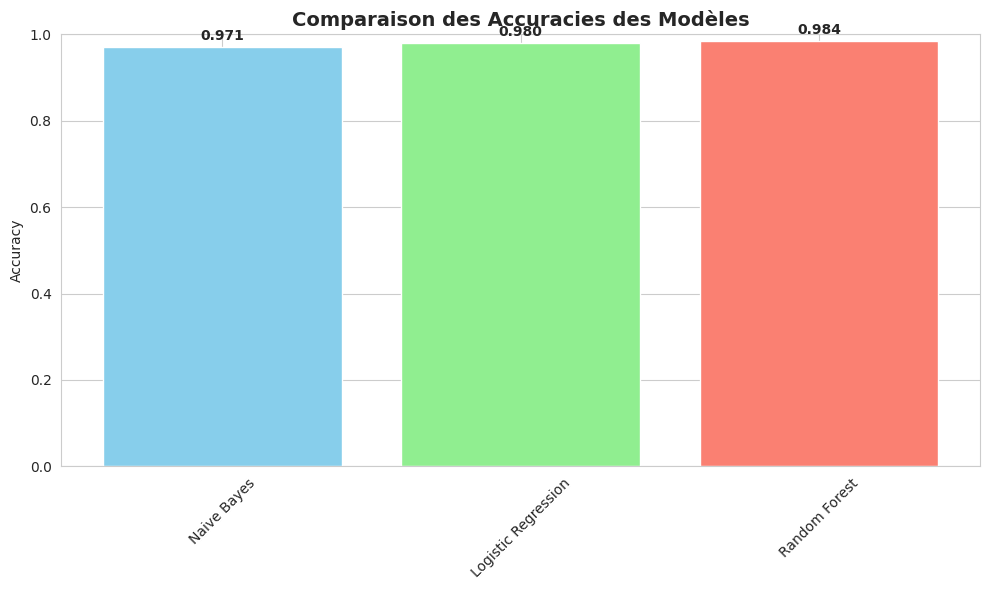

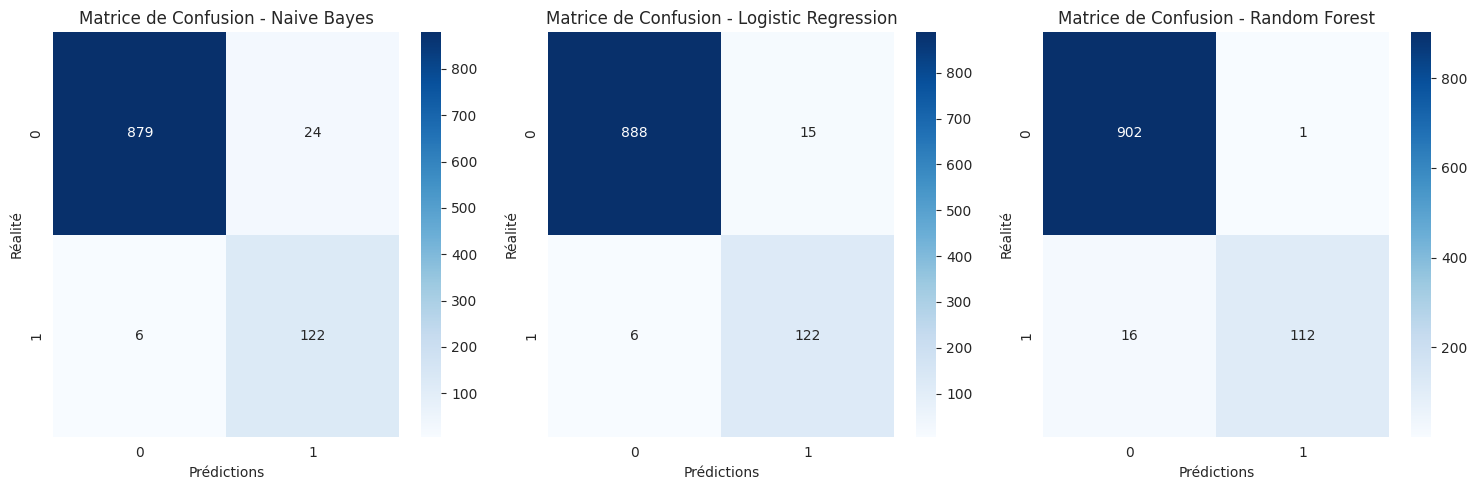

In [ ]:
print("\n📈 VISUALISATION DES RÉSULTATS")

# Comparaison des accuracies
accuracies = {name: res['accuracy'] for name, res in results.items()}

plt.figure(figsize=(10, 6))
bars = plt.bar(accuracies.keys(), accuracies.values(), color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Comparaison des Accuracies des Modèles', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# Ajouter les valeurs sur les barres
for bar, acc in zip(bars, accuracies.values()):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Matrices de confusion
fig, axes = plt.subplots(1, len(results), figsize=(15, 5))
if len(results) == 1:
    axes = [axes]

for idx, (name, res) in enumerate(results.items()):
    cm = confusion_matrix(y_test, res['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'Matrice de Confusion - {name}')
    axes[idx].set_xlabel('Prédictions')
    axes[idx].set_ylabel('Réalité')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import f1_score

print("\n📊 VÉRIFICATION DE L'OVERFITTING")

overfit_report = {}

for name, model in trained_models.items():
    print(f"\n🔍 {name.upper()}")

    # Prédictions sur train et test
    y_pred_train = model.predict(X_train_balanced)
    y_pred_test = model.predict(X_test_tfidf)

    # F1-macro pour mesurer la performance globale
    train_f1 = f1_score(y_train_balanced, y_pred_train, average='macro')
    test_f1 = f1_score(y_test, y_pred_test, average='macro')

    diff = train_f1 - test_f1
    flag_overfit = diff > 0.08  # seuil pratique pour suspecter overfitting

    overfit_report[name] = {
        'train_f1': train_f1,
        'test_f1': test_f1,
        'diff': diff,
        'overfitting_suspected': flag_overfit
    }

    print(f"Train F1-macro: {train_f1:.4f}")
    print(f"Test F1-macro : {test_f1:.4f}")
    print(f"Diff           : {diff:.4f} {'⚠️ Overfitting suspecté' if flag_overfit else '✅ OK'}")

# Optionnel : afficher tous les résultats dans un DataFrame
import pandas as pd
report_df = pd.DataFrame(overfit_report).T
report_df



📊 VÉRIFICATION DE L'OVERFITTING

🔍 NAIVE BAYES
Train F1-macro: 0.9803
Test F1-macro : 0.9369
Diff           : 0.0434 ✅ OK

🔍 LOGISTIC REGRESSION
Train F1-macro: 0.9685
Test F1-macro : 0.9545
Diff           : 0.0140 ✅ OK

🔍 RANDOM FOREST
Train F1-macro: 0.9999
Test F1-macro : 0.9601
Diff           : 0.0398 ✅ OK


,train_f1,test_f1,diff,overfitting_suspected
Naive Bayes,0.980316,0.936866,0.04345,False
Logistic Regression,0.968517,0.954534,0.013983,False
Random Forest,0.999861,0.960063,0.039799,False


*Interprétation* :


Tous les modèles présentent une différence modérée entre train et test, ce qui indique qu’il n’y a pas d’overfitting sévère.

Les performances restent stables et fiables sur des données nouvelles.

Random Forest montre une capacité élevée sur le train mais reste généralisé sur le test, ce qui est acceptable pour ce type de modèle.

In [ ]:
def test_message(message, model, vectorizer, threshold=0.4):
    """
    Teste un message texte avec un modèle entraîné et un seuil de probabilité.

    Args:
        message (str)       : texte à tester
        model               : modèle déjà entraîné
        vectorizer          : TF-IDF vectorizer entraîné sur le dataset
        threshold (float)   : seuil pour considérer un message comme spam (par défaut 0.4)

    Returns:
        dict : {'message', 'prediction', 'probability'}
    """
    # Prétraitement
    cleaned = preprocess_spam(message)

    # Transformation TF-IDF
    X_msg = vectorizer.transform([cleaned])

    # Probabilité de spam si disponible
    probability = model.predict_proba(X_msg)[:, 1][0] if hasattr(model, 'predict_proba') else None

    # Prédiction selon le seuil
    if probability is not None:
        prediction = 'spam' if probability >= threshold else 'ham'
    else:
        # si predict_proba n'est pas disponible, utiliser predict() par défaut
        prediction = model.predict(X_msg)[0]

    return {
        'message': message,
        'prediction': prediction,
        'probability': probability
    }

# Exemple d'utilisation
message_test = "Congratulations! 🎉 You’ve been selected to win a FREE iPhone 15!  Click here 👉 http://bit.ly/win-iphone to claim your prize now. Offer valid for the next 24 hours only!."
result = test_message(message_test, trained_models['Logistic Regression'], tfidf, threshold=0.4)

cleaned = preprocess_spam(message_test)
print(f"Message : {result['message']}")
print(f"Prédiction : {result['prediction']}")
if result['probability'] is not None:
    print(f"Probabilité de spam : {result['probability']:.4f}")
print(f"Message nettoyé : {cleaned}")

Message : Congratulations! 🎉 You’ve been selected to win a FREE iPhone 15!  Click here 👉 http://bit.ly/win-iphone to claim your prize now. Offer valid for the next 24 hours only!.
Prédiction : spam
Probabilité de spam : 0.9772
Message nettoyé : congratulations! youv select win free iphon ! click claim prize offer valid next hour only!


# Deploiement :

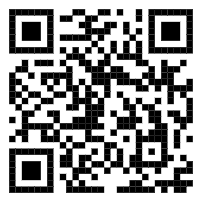